In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
#import thư viện cần thiết
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


READ DATA

In [3]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")[['ProductId','Score','Text']].dropna()
df.head()

,ProductId,Score,Text
0,B001E4KFG0,5,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,This is a confection that has been around a fe...
3,B000UA0QIQ,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy at a great price. There was a wid...


**EXPLORE DATA BEFORE CLEANING**

In [4]:
# Data Shape
print("Data Shape:", df.shape)

# Data Types
print("\nData Types:\n", df.dtypes)

# Rating Distribution
print("\nRating Distribution:")
print(df['Score'].value_counts())
print("\nAverage Rating:", df['Score'].mean())

# Missing Values
print("\nMissing Values:\n", df.isnull().sum())

# Textual Data Overview (Average Review Length)
print("\nAverage Review Length:", df['Text'].str.len().mean())

Data Shape: (568454, 3)

Data Types:
 ProductId    object
Score         int64
Text         object
dtype: object

Rating Distribution:
Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

Average Rating: 4.183198640523243

Missing Values:
 ProductId    0
Score        0
Text         0
dtype: int64

Average Review Length: 436.22208305333413


In [5]:
print("\nColumn Exploration:")
for column in df.columns:
  print(f"\nColumn: {column}")
  print("Unique values:", df[column].nunique())
  print("Example values:", df[column].unique()[:5])
  if df[column].dtype == object:
    print("Number of missing values:", df[column].isnull().sum())


Column Exploration:

Column: ProductId
Unique values: 74258
Example values: ['B001E4KFG0' 'B00813GRG4' 'B000LQOCH0' 'B000UA0QIQ' 'B006K2ZZ7K']
Number of missing values: 0

Column: Score
Unique values: 5
Example values: [5 1 4 2 3]

Column: Text
Unique values: 393579
Example values: ['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  No

**CLEANING DATA**

In [6]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
  """Cleans the review text by removing punctuation, converting to lowercase, and removing stop words."""
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

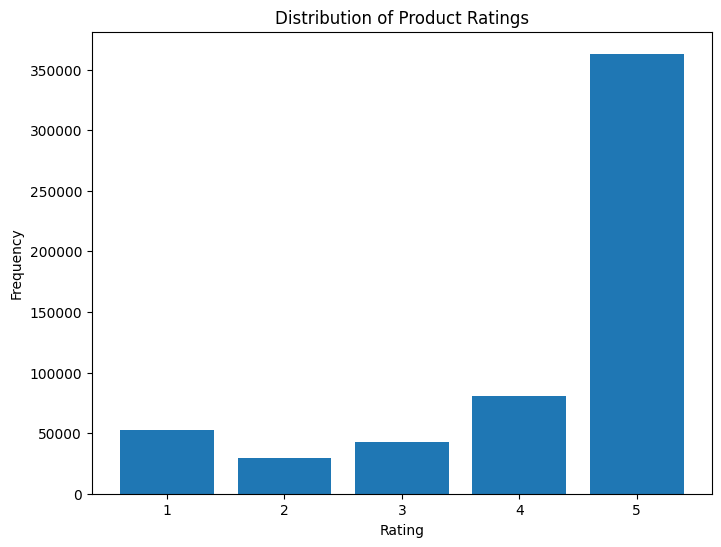

In [7]:
# Calculate the frequency of each rating value
rating_counts = df['Score'].value_counts()

# Visualize the rating distribution using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

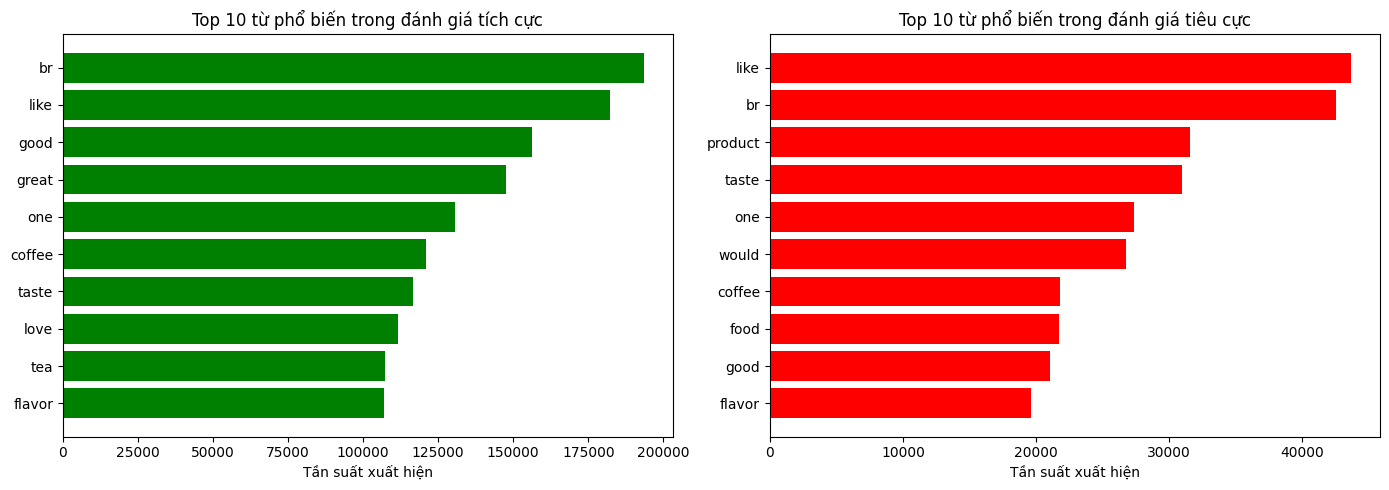

In [8]:
# Phân loại đánh giá tích cực (4,5) và tiêu cực (1,2)
positive_reviews = df[df['Score'].isin([4, 5])]['Cleaned_Text']
negative_reviews = df[df['Score'].isin([1, 2])]['Cleaned_Text']

# Kết hợp tất cả từ của từng nhóm
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Tokenize the text into words
positive_words = word_tokenize(positive_text)
negative_words = word_tokenize(negative_text)

# Tính tần suất từ
positive_freq = FreqDist(positive_words)
negative_freq = FreqDist(negative_words)

# Lấy top 10 từ phổ biến nhất
top_positive = positive_freq.most_common(10)
top_negative = negative_freq.most_common(10)

# Chuyển dữ liệu sang dạng danh sách
pos_words, pos_counts = zip(*top_positive)
neg_words, neg_counts = zip(*top_negative)

# Vẽ biểu đồ tần suất từ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ cho đánh giá tích cực
axes[0].barh(pos_words[::-1], pos_counts[::-1], color='green')
axes[0].set_title("Top 10 từ phổ biến trong đánh giá tích cực")
axes[0].set_xlabel("Tần suất xuất hiện")

# Biểu đồ cho đánh giá tiêu cực
axes[1].barh(neg_words[::-1], neg_counts[::-1], color='red')
axes[1].set_title("Top 10 từ phổ biến trong đánh giá tiêu cực")
axes[1].set_xlabel("Tần suất xuất hiện")

plt.tight_layout()
plt.show()

Average Review Length: 41.49
Median Review Length: 29.00


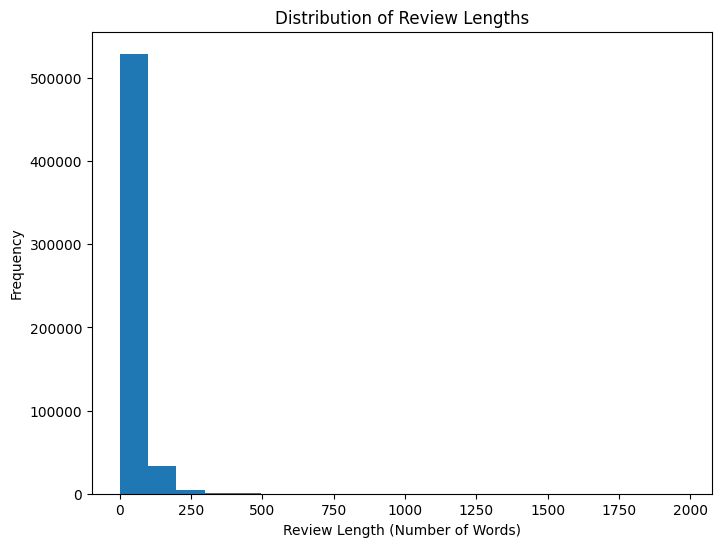

In [9]:
# Calculate the length of each review (number of words)
df['Review_Length'] = df['Cleaned_Text'].apply(lambda x: len(str(x).split()))

# Calculate the average and median review length
average_length = df['Review_Length'].mean()
median_length = df['Review_Length'].median()

print(f"Average Review Length: {average_length:.2f}")
print(f"Median Review Length: {median_length:.2f}")

# Create a histogram of the review lengths
plt.figure(figsize=(8, 6))
plt.hist(df['Review_Length'], bins=20)
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [10]:
# Calculate the average rating
average_rating = df['Score'].mean()
print(f"Average Rating: {average_rating}")

# Analyze the distribution of ratings
rating_distribution = df['Score'].value_counts()
print("\nRating Distribution:\n", rating_distribution)

# Since the 'ProductId' is available, we can group by product and calculate the average rating for each product
product_average_rating = df.groupby('ProductId')['Score'].mean()
print("\nAverage Rating by Product:\n", product_average_rating.head(10))

Average Rating: 4.183198640523243

Rating Distribution:
 Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

Average Rating by Product:
 ProductId
0006641040    4.351351
141278509X    5.000000
2734888454    3.500000
2841233731    5.000000
7310172001    4.751445
7310172101    4.751445
7800648702    4.000000
9376674501    5.000000
B00002N8SM    1.789474
B00002NCJC    4.500000
Name: Score, dtype: float64


In [11]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for a given review
def get_sentiment_score(review):
    scores = analyzer.polarity_scores(review)
    return scores['compound']

# Apply the function to the 'Cleaned_Text' column to get sentiment scores
df['Sentiment_Score'] = df['Cleaned_Text'].apply(get_sentiment_score)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Category'] = df['Sentiment_Score'].apply(categorize_sentiment)

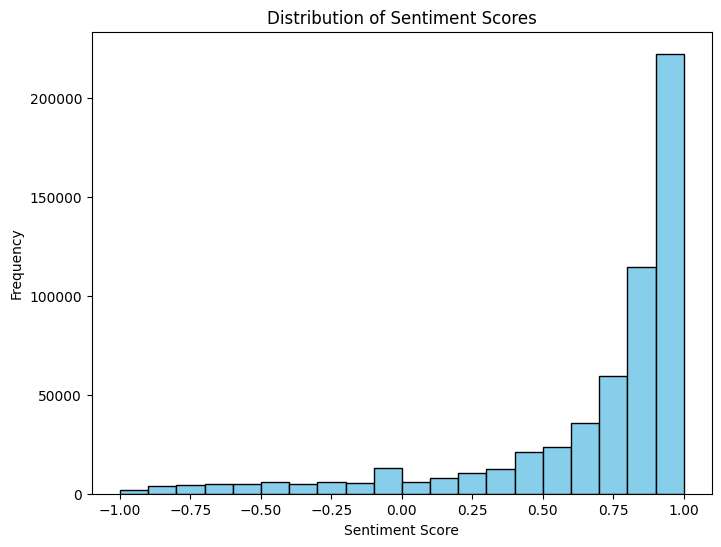

In [12]:
import matplotlib.pyplot as plt

# Sentiment Score Distribution
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

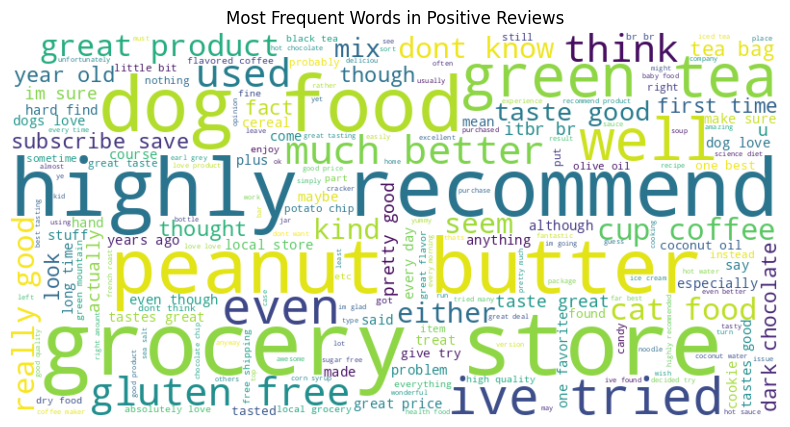

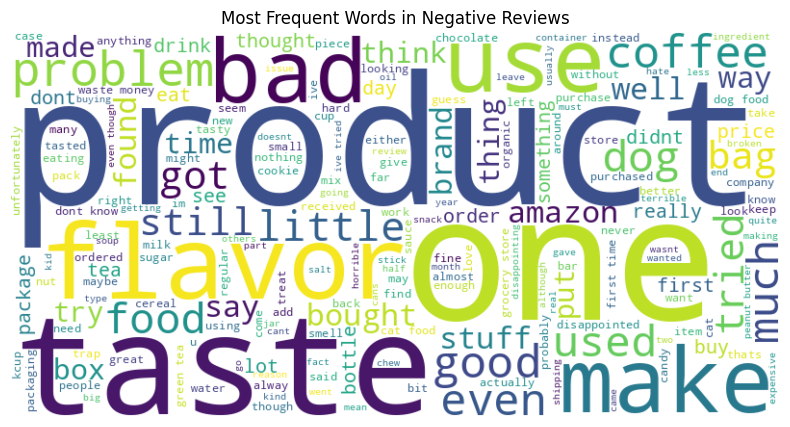

In [13]:
# Positive reviews word cloud
positive_reviews = df[df['Sentiment_Category'] == 'Positive']['Cleaned_Text']
positive_text = ' '.join(positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()

# Negative reviews word cloud
negative_reviews = df[df['Sentiment_Category'] == 'Negative']['Cleaned_Text']
negative_text = ' '.join(negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')
plt.show()